# OCR text detection 

This section will introduce how to use PaddleOCR to complete the training and operation of the text detection DB algorithm, including:
1. Quickly call PaddleOCR package to experience text detection
2. Understand the principle of text detection DB algorithm
3. Master the text detection model construction process
4. Master the text detection model training process

Note: `paddleocr` refers to `PaddleOCR whl package`.


In [ ]:
!pip install --upgrade pip
!pip install paddleocr

In [ ]:
import os
# Modify the default directory where Aistudio code runs to /home/aistudio/
os.chdir("/home/aistudio/")

In [ ]:
# `--image_dir`` point to the image path to be predicted; `--rec`` false means no recognition is used, only text detection is performed
!paddleocr --image_dir ./12.jpg --rec false

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:241: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=np.bool)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:256: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0

In addition to using the command line, `paddleocr` also provides a code calling method, as follows:

In [ ]:
# 1. Import PaddleOCR class from paddleocr
from paddleocr import PaddleOCR

# 2. Declare the PaddleOCR class
ocr = PaddleOCR()
img_path ='./12.jpg'
# 3. Perform prediction
result = ocr.ocr(img_path, rec=False)
print(f"The predicted text box of {img_path} are follows.")
print(result)

[2021/12/22 21:07:58] root WARNING: version 2.1 not support cls models, use version 2.0 instead
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.2.1/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.2.1/ocr/det/ch/ch_PP-OCRv2_det_infer', det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_polygon=True, e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set='totaltext', enable_mkldnn=False, gpu_mem=500, help='=

**Visualized text detection prediction results**

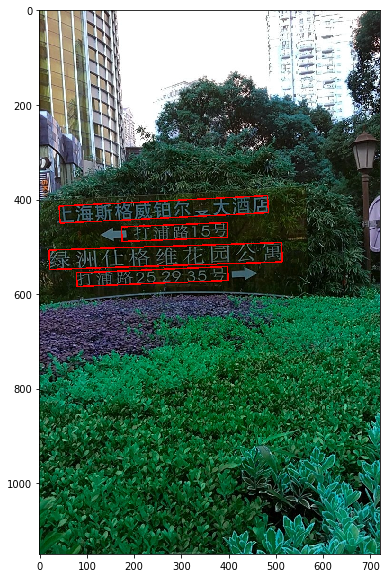

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# When using matplotlib.pyplot to draw in the notebook, you need to add this command to display
%matplotlib inline

# 4. Visual inspection results
image = cv2.imread(img_path)
boxes = [line[0] for line in result]
for box in result:
     box = np.reshape(np.array(box), [-1, 1, 2]).astype(np.int64)
     image = cv2.polylines(np.array(image), [box], True, (255, 0, 0), 2)

# Draw the read picture
plt.figure(figsize=(10, 10))
plt.imshow(image)


# 2. Detailed Implementation of DB Text Detection Algorithm


## 2.1 DB Text Detection Algorithm Principle


[DB](https://arxiv.org/pdf/1911.08947.pdf) is a segmentation-based text detection algorithm, which proposes a Differentiable Threshold Differentiable Binarization module (DB module) that uses a dynamic threshold to distinguish the text area from the background.

The process of the segmentation-based ordinary text detection algorithm is shown by the blue arrow in the above figure. After this method obtains the segmentation result, a fixed threshold is used to obtain the binarized segmentation map, and then heuristic algorithms such as pixel clustering are used to obtain Text area.

The flow of the DB algorithm is shown by the red arrow in the figure. The biggest difference is that DB has a threshold map, which uses the network to predict the threshold at each position of the picture, instead of using a fixed value to better separate the text background and the foreground. .

The DB algorithm has the following advantages:
1. The algorithm structure is simple, without tedious post-processing
2. Have good accuracy and performance on open source data


In the traditional image segmentation algorithm, after obtaining the probability map, the standard binarize method is used for processing. The pixels below the threshold are set to 0, and the pixels above the threshold are set to 1. The formula is as follows:
$$ B_{i,j}=\left\{
\begin{aligned}
1, if P_{i,j} >= t ,\\
0, otherwise.
\end{aligned}
\right.
$$
But the standard binarization method is not differentiable, making the network unable to train end-to-end. To solve this problem, the DB algorithm proposes Differentiable Binarization (DB). Differentiable binarization approximates the step function in standard binarization, using the following formula to replace:
$$
\hat{B} = \frac{1}{1 + e^{-k(P_{i,j}-T_{i,j})}}
$$
Among them, P is the probability map obtained above, T is the threshold map obtained above, and k is the gain factor. In the experiment, it is selected as 50 based on experience. The comparison chart of standard binarization and differentiable binarization is shown in **Figure 2(a)** below.

When using cross-entropy loss, the loss of positive and negative samples are $l_+$ and $l_-$ respectively:
$$
l_+ = -log(\frac{1}{1 + e^{-k(P_{i,j}-T_{i,j})}})
$$
$$
l_- = -log(1-\frac{1}{1 + e^{-k(P_{i,j}-T_{i,j})}})
$$
Taking the partial derivative of the input $x$ will give:
$$
\frac{\delta{l_+}}{\delta{x}} = -kf(x)e^{-kx}
$$
$$
\frac{\delta{l_-}}{\delta{x}} = -kf(x)
$$
It can be found that the enhancement factor will amplify the gradient of the error prediction, thereby optimizing the model to obtain better results. **Figure 2(b)**, the part of $x<0$ is the case where positive samples are predicted to be negative samples. It can be seen that the gain factor k amplifies the gradient; while **Figure 2(c)** The part where $x>0$ is a negative sample is predicted to be a positive sample, the gradient is also magnified.




## 2.2 DB Text Detection Model Construction


The DB text detection model can be divided into three parts:
- Backbone network, responsible for extracting image features
- FPN network, feature pyramid structure enhanced features
- Head network, calculate the probability map of the text area


**backbone network**

The Backbone part of the DB text detection network uses an image classification network. In the paper, ResNet50 is used. In this section of the experiment, in order to speed up the training, the MobileNetV3 large structure is used as the backbone.

In [ ]:
import os

!pip install --upgrade pip
!pip install -r requirements.txt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:

from ppocr.modeling.backbones.det_mobilenet_v3 import MobileNetV3


DB's Backbone is used to extract the multi-scale features of the image, as shown in the following code, assuming the input shape is [640, 640], the output of the backbone network has four features, the shapes of which are [1, 16, 160, 160] , [1, 24, 80, 80], [1, 56, 40, 40], [1, 480, 20, 20].
These features will be input to the feature pyramid FPN network for further enhancement features.

In [ ]:
import paddle

fake_inputs = paddle.randn([1, 3, 640, 640], dtype="float32")

# 1. Declare Backbone
model_backbone = MobileNetV3()
model_backbone.eval()

# 2. Perform prediction
outs = model_backbone(fake_inputs)

# 3. Print network structure
print(model_backbone)

# 4. Print out the characteristic shape
for idx, out in enumerate(outs):
     print("The index is ", idx, "and the shape of output is ", out.shape)

MobileNetV3(
  (conv): ConvBNLayer(
    (conv): Conv2D(3, 8, kernel_size=[3, 3], stride=[2, 2], padding=1, data_format=NCHW)
    (bn): BatchNorm()
  )
  (stage0): Sequential(
    (0): ResidualUnit(
      (expand_conv): ConvBNLayer(
        (conv): Conv2D(8, 8, kernel_size=[1, 1], data_format=NCHW)
        (bn): BatchNorm()
      )
      (bottleneck_conv): ConvBNLayer(
        (conv): Conv2D(8, 8, kernel_size=[3, 3], padding=1, groups=8, data_format=NCHW)
        (bn): BatchNorm()
      )
      (linear_conv): ConvBNLayer(
        (conv): Conv2D(8, 8, kernel_size=[1, 1], data_format=NCHW)
        (bn): BatchNorm()
      )
    )
    (1): ResidualUnit(
      (expand_conv): ConvBNLayer(
        (conv): Conv2D(8, 32, kernel_size=[1, 1], data_format=NCHW)
        (bn): BatchNorm()
      )
      (bottleneck_conv): ConvBNLayer(
        (conv): Conv2D(32, 32, kernel_size=[3, 3], stride=[2, 2], padding=1, groups=32, data_format=NCHW)
        (bn): BatchNorm()
      )
      (linear_conv): ConvBNLa

**FPN Network**

Feature pyramid structure FPN is a common method for convolutional networks to efficiently extract features of each dimension in a picture.

In [ ]:


import paddle
from paddle import nn
import paddle.nn.functional as F
from paddle import ParamAttr

class DBFPN(nn.Layer):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(DBFPN, self).__init__()
        self.out_channels = out_channels

     

    def forward(self, x):
        c2, c3, c4, c5 = x

        in5 = self.in5_conv(c5)
        in4 = self.in4_conv(c4)
        in3 = self.in3_conv(c3)
        in2 = self.in2_conv(c2)

        # Feature upsampling
        out4 = in4 + F.upsample(
            in5, scale_factor=2, mode="nearest", align_mode=1)  # 1/16
        out3 = in3 + F.upsample(
            out4, scale_factor=2, mode="nearest", align_mode=1)  # 1/8
        out2 = in2 + F.upsample(
            out3, scale_factor=2, mode="nearest", align_mode=1)  # 1/4

        p5 = self.p5_conv(in5)
        p4 = self.p4_conv(out4)
        p3 = self.p3_conv(out3)
        p2 = self.p2_conv(out2)

        # Feature upsampling
        p5 = F.upsample(p5, scale_factor=8, mode="nearest", align_mode=1)
        p4 = F.upsample(p4, scale_factor=4, mode="nearest", align_mode=1)
        p3 = F.upsample(p3, scale_factor=2, mode="nearest", align_mode=1)

        fuse = paddle.concat([p5, p4, p3, p2], axis=1)
        return fuse

The input of the FPN network is the output of the Backbone part, and the height and width of the output feature map are one-fourth of the original image. Assuming that the shape of the input image is [1, 3, 640, 640], the height and width of the FPN output feature are [160, 160].

In [ ]:
import paddle 

# 1. Import DBFPN from PaddleOCR
from ppocr.modeling.necks.db_fpn import DBFPN

# 2. Obtain Backbone network output results
fake_inputs = paddle.randn([1, 3, 640, 640], dtype="float32")
model_backbone = MobileNetV3()
in_channles = model_backbone.out_channels

# 3. Declare FPN network
model_fpn = DBFPN(in_channels=in_channles, out_channels=256)

# 4. Print FPN network
print(model_fpn)

# 5. Calculate FPN result output
outs = model_backbone(fake_inputs)
fpn_outs = model_fpn(outs)

# 6. Print FPN output characteristic shape
print(f"The shape of fpn outs {fpn_outs.shape}")

DBFPN(
  (in2_conv): Conv2D(16, 256, kernel_size=[1, 1], data_format=NCHW)
  (in3_conv): Conv2D(24, 256, kernel_size=[1, 1], data_format=NCHW)
  (in4_conv): Conv2D(56, 256, kernel_size=[1, 1], data_format=NCHW)
  (in5_conv): Conv2D(480, 256, kernel_size=[1, 1], data_format=NCHW)
  (p5_conv): Conv2D(256, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
  (p4_conv): Conv2D(256, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
  (p3_conv): Conv2D(256, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
  (p2_conv): Conv2D(256, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
)
The shape of fpn outs [1, 256, 160, 160]


**Head Network**

Calculate the text area probability map, the text area threshold map and the text area binary map.

In [ ]:
import math
import paddle
from paddle import nn
import paddle.nn.functional as F
from paddle import ParamAttr

class DBHead(nn.Layer):
    """
    Differentiable Binarization (DB) for text detection:
        see https://arxiv.org/abs/1911.08947
    args:
        params(dict): super parameters for build DB network
    """

    def __init__(self, in_channels, k=50, **kwargs):
        super(DBHead, self).__init__()
        self.k = k

  

    def step_function(self, x, y):
       
        return paddle.reciprocal(1 + paddle.exp(-self.k * (x - y)))

    def forward(self, x, targets=None):
        shrink_maps = self.binarize(x)
        if not self.training:
            return {'maps': shrink_maps}

        threshold_maps = self.thresh(x)
        binary_maps = self.step_function(shrink_maps, threshold_maps)
        y = paddle.concat([shrink_maps, threshold_maps, binary_maps], axis=1)
        return {'maps': y}

The DB Head network will perform up-sampling on the basis of the FPN feature, and map the FPN feature from a quarter of the size of the original image to the size of the original image.

In [ ]:

from ppocr.modeling.heads.det_db_head import DBHead
import paddle 

# 2. Calculate DBFPN network output results
fake_inputs = paddle.randn([1, 3, 640, 640], dtype="float32")
model_backbone = MobileNetV3()
in_channles = model_backbone.out_channels
model_fpn = DBFPN(in_channels=in_channles, out_channels=256)
outs = model_backbone(fake_inputs)
fpn_outs = model_fpn(outs)

# 3. Declare Head network
model_db_head = DBHead(in_channels=256)

# 4. Print DBhead network
print(model_db_head)

# 5. Calculate the output of the Head network
db_head_outs = model_db_head(fpn_outs)
print(f"The shape of fpn outs {fpn_outs.shape}")
print(f"The shape of DB head outs {db_head_outs['maps'].shape}")


DBHead(
  (binarize): Head(
    (conv1): Conv2D(256, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
    (conv_bn1): BatchNorm()
    (conv2): Conv2DTranspose(64, 64, kernel_size=[2, 2], stride=[2, 2], data_format=NCHW)
    (conv_bn2): BatchNorm()
    (conv3): Conv2DTranspose(64, 1, kernel_size=[2, 2], stride=[2, 2], data_format=NCHW)
  )
  (thresh): Head(
    (conv1): Conv2D(256, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
    (conv_bn1): BatchNorm()
    (conv2): Conv2DTranspose(64, 64, kernel_size=[2, 2], stride=[2, 2], data_format=NCHW)
    (conv_bn2): BatchNorm()
    (conv3): Conv2DTranspose(64, 1, kernel_size=[2, 2], stride=[2, 2], data_format=NCHW)
  )
)
The shape of fpn outs [1, 256, 160, 160]
The shape of DB head outs [1, 3, 640, 640]


# 3 Train the DB Text Detection Model
 provides DB text detection algorithms, supports two backbone networks, MobileNetV3 and ResNet50_vd. You can select the corresponding configuration file and start training according to your needs.

This section takes the icdar15 dataset and MobileNetV3 as the backbone network DB detection model (that is, the configuration used by the ultra-lightweight model) as an example to introduce how to complete the training, evaluation and testing of the  Chinese text detection model.

## 3.1 Data Preparation

This experiment selected ICDAR2015, the most well-known and commonly used data set for Scene Text Detection and Recognition tasks. The schematic diagram of the icdar2015 data set is shown in the figure below:



In [ ]:
!cd ~/data/data96799/ && tar xf icdar2015.tar 

After running the above command, ~/train_data/icdar2015/text_localization has two folders and two files, which are:
```
~/train_data/icdar2015/text_localization
  └─ Training data of icdar_c4_train_imgs/ icdar dataset
  └─ ch4_test_images/ test data of icdar data set
  └─ train_icdar2015_label.txt icdar data set training label
  └─ test_icdar2015_label.txt icdar data set test label
```
The format of the annotation file provided is:
```
"Image file name json.dumps encoded image annotation information"
ch4_test_images/img_61.jpg [{"transcription": "MASA", "points": [[310, 104], [416, 141], [418, 216], [312, 179]], ...}]
```

The image annotation information before json.dumps encoding is a list containing multiple dictionaries. The points in the dictionary represent the coordinates (x, y) of the four points of the text box, which are arranged clockwise from the point in the upper left corner. The field in transcription represents the text of the current text box, and this information is not needed in the text detection task. If you want to train OCR on other data sets, you can construct the annotation file in the above form.

If the text in the "transcription" field is '*' or '###', it means that the corresponding annotation can be ignored. Therefore, if there is no text label, the transcription field can be set to an empty string.


## 3.2 Data Preprocessing

During training, there are certain requirements for the format and size of the input picture. At the same time, it is also necessary to obtain the true label of the threshold map and the probability map according to the labeling information. Therefore, before the data is input to the model, the data needs to be preprocessed to make the pictures and labels meet the needs of network training and prediction. In addition, in order to expand the training data set, suppress over-fitting, and improve the generalization ability of the model, several basic data augmentation methods need to be used.

The data preprocessing of this experiment includes the following methods:

-Image decoding: convert the image to Numpy format;
-Label encoding: parse the label information in the txt file and save it in a unified format;
-Basic data augmentation: including: random horizontal flip, random rotation, random zoom, random crop, etc.;
-Obtain threshold map label: use the expansion method to obtain the threshold map label required for algorithm training;
-Obtain the probability map label: use the shrinking method to obtain the probability map label required for algorithm training;
-Normalization: Through normalization, the input value distribution of any neuron in each layer of the neural network is changed to a standard normal distribution with a mean value of 0 and a variance of 1, so that the optimization process of the optimal solution will obviously become smooth. The training process is easier to converge;
-Channel transformation: The image data format is [H, W, C] (that is, the height, width, and number of channels), and the training data format used by the neural network is [C, H, W], so the image data needs to be updated Arrangement, for example, [224, 224, 3] becomes [3, 224, 224];


**Image Decoding**

In [ ]:
import sys
import six
import cv2
import numpy as np

In [ ]:

class DecodeImage(object):
    """ decode image """

    def __init__(self, img_mode='RGB', channel_first=False, **kwargs):
        self.img_mode = img_mode
        self.channel_first = channel_first

    def __call__(self, data):
        img = data['image']
        if six.PY2:
            assert type(img) is str and len(
                img) > 0, "invalid input 'img' in DecodeImage"
        else:
            assert type(img) is bytes and len(
                img) > 0, "invalid input 'img' in DecodeImage"
        # 1. Image decoding
        img = np.frombuffer(img, dtype='uint8')
        img = cv2.imdecode(img, 1)

        if img is None:
            return None
        if self.img_mode == 'GRAY':
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif self.img_mode == 'RGB':
            assert img.shape[2] == 3, 'invalid shape of image[%s]' % (img.shape)
            img = img[:, :, ::-1]

        if self.channel_first:
            img = img.transpose((2, 0, 1))
        # 2. The decoded image is placed in the dictionary
        data['image'] = img
        return data

Next, read the image from the annotations of the training data to demonstrate the use of the DecodeImage class.

In [ ]:
import json
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
# When using matplotlib.pyplot to draw in the notebook, you need to add this command to display
%matplotlib inline
from PIL import Image
import numpy as np


label_path = "/home/aistudio/data/data96799/icdar2015/text_localization/train_icdar2015_label.txt"
img_dir = "/home/aistudio/data/data96799/icdar2015/text_localization/"

# 1. Read the first data of the training label
f = open(label_path, "r")
lines = f.readlines()

# 2. Fetch the first data
line = lines[0]

print("The first data in train_icdar2015_label.txt is as follows.\n", line)
img_name, gt_label = line.strip().split("\t")

# 3. Read image
image = open(os.path.join(img_dir, img_name), 'rb').read()
data = {'image': image, 'label': gt_label}



The first data in train_icdar2015_label.txt is as follows.
 icdar_c4_train_imgs/img_61.jpg	[{"transcription": "###", "points": [[427, 293], [469, 293], [468, 315], [425, 314]]}, {"transcription": "###", "points": [[480, 291], [651, 289], [650, 311], [479, 313]]}, {"transcription": "Ave", "points": [[655, 287], [698, 287], [696, 309], [652, 309]]}, {"transcription": "West", "points": [[701, 285], [759, 285], [759, 308], [701, 308]]}, {"transcription": "YOU", "points": [[1044, 531], [1074, 536], [1076, 585], [1046, 579]]}, {"transcription": "CAN", "points": [[1077, 535], [1114, 539], [1117, 595], [1079, 585]]}, {"transcription": "PAY", "points": [[1119, 539], [1160, 543], [1158, 601], [1120, 593]]}, {"transcription": "LESS?", "points": [[1164, 542], [1252, 545], [1253, 624], [1166, 602]]}, {"transcription": "Singapore's", "points": [[1032, 177], [1185, 73], [1191, 143], [1038, 223]]}, {"transcription": "no.1", "points": [[1190, 73], [1270, 19], [1278, 91], [1194, 133]]}]



Declare the `DecodeImage` class, decode the image, and return a new dictionary data.

The shape of decoded image is  (720, 1280, 3)


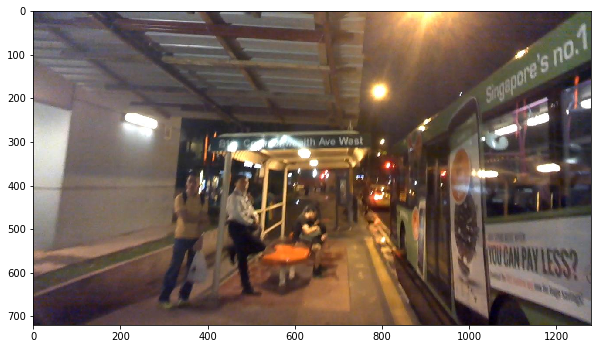

In [ ]:
# 4. Declare the DecodeImage class to decode the image
decode_image = DecodeImage(img_mode='RGB', channel_first=False)
data = decode_image(data)

# 5. Print the shape of the decoded image and visualize the image
print("The shape of decoded image is ", data['image'].shape)

plt.figure(figsize=(10, 10))
plt.imshow(data['image'])
src_img = data['image']

**Label Code**

Analyze the label information in the txt file and save it in a unified format.

In [ ]:
import numpy as np
import string
import json


class DetLabelEncode(object):
    def __init__(self, **kwargs):
        pass

    def __call__(self, data):
        label = data['label']
        # 1. Use json to read tags
        label = json.loads(label)
        nBox = len(label)
        boxes, txts, txt_tags = [], [], []
        for bno in range(0, nBox):
            box = label[bno]['points']
            txt = label[bno]['transcription']
            boxes.append(box)
            txts.append(txt)
            # 1.1 If the text label is * or ###, it means this label is invalid
            if txt in ['*', '###']:
                txt_tags.append(True)
            else:
                txt_tags.append(False)
        if len(boxes) == 0:
            return None
        boxes = self.expand_points_num(boxes)
        boxes = np.array(boxes, dtype=np.float32)
        txt_tags = np.array(txt_tags, dtype=np.bool)
        
        # 2. Get text, box and other information
        data['polys'] = boxes
        data['texts'] = txts
        data['ignore_tags'] = txt_tags
        return data

Run the following code to observe the comparison before and after the DetLabelEncode class decodes the label.

In [ ]:

from ppocr.data.imaug.label_ops import DetLabelEncode

# 1. Declare the class for label decoding
decode_label = DetLabelEncode()

# 2. Print the label before decoding
print("The label before decode are: ", data['label'])

# 3. Label decoding
data = decode_label(data)
print("\n")

# 4. Print the decoded label
print("The polygon after decode are: ", data['polys'])
print("The text after decode are: ", data['texts'])


The label before decode are:  [{"transcription": "###", "points": [[427, 293], [469, 293], [468, 315], [425, 314]]}, {"transcription": "###", "points": [[480, 291], [651, 289], [650, 311], [479, 313]]}, {"transcription": "Ave", "points": [[655, 287], [698, 287], [696, 309], [652, 309]]}, {"transcription": "West", "points": [[701, 285], [759, 285], [759, 308], [701, 308]]}, {"transcription": "YOU", "points": [[1044, 531], [1074, 536], [1076, 585], [1046, 579]]}, {"transcription": "CAN", "points": [[1077, 535], [1114, 539], [1117, 595], [1079, 585]]}, {"transcription": "PAY", "points": [[1119, 539], [1160, 543], [1158, 601], [1120, 593]]}, {"transcription": "LESS?", "points": [[1164, 542], [1252, 545], [1253, 624], [1166, 602]]}, {"transcription": "Singapore's", "points": [[1032, 177], [1185, 73], [1191, 143], [1038, 223]]}, {"transcription": "no.1", "points": [[1190, 73], [1270, 19], [1278, 91], [1194, 133]]}]


The polygon after decode are:  [[[ 427.  293.]
  [ 469.  293.]
  [ 468.  31

**Basic data augmentation**

Data augmentation is a common method to improve model training accuracy and increase model generalization. Commonly used data augmentation for text detection includes random horizontal flipping, random rotation, random scaling, and random cropping.

Random horizontal flip, random rotation, random zoom code implementation reference [Code](https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/ppocr/data/imaug/iaa_augment.py). Random cropped data augmentation code implementation reference [Code](https://github.com/PaddlePaddle/PaddleOCR/blob/81ee76ad7f9ff534a0ae5439d2a5259c4263993c/ppocr/data/imaug/random_crop_data.py?_pjax=%23js-repo-pjax-pjax-%2C%20div%5Bitemtype%3D%22http%3A%2F%2Fschema.org%2FSoftwareSourceCode%22%5D%20main%2C%20%5Bdata-pjax-container%5D#L127).


**Get the threshold map label**

Use the expansion method to obtain the threshold map label required for algorithm training;


In [ ]:
import numpy as np
import cv2

np.seterr(divide='ignore', invalid='ignore')
import pyclipper
from shapely.geometry import Polygon
import sys
import warnings

warnings.simplefilter("ignore")

class MakeBorderMap(object):
    def __init__(self,
                 shrink_ratio=0.4,
                 thresh_min=0.3,
                 thresh_max=0.7,
                 **kwargs):
        self.shrink_ratio = shrink_ratio
        self.thresh_min = thresh_min
        self.thresh_max = thresh_max

    def __call__(self, data):

        img = data['image']
        text_polys = data['polys']
        ignore_tags = data['ignore_tags']

        # 1. Generate empty template
        canvas = np.zeros(img.shape[:2], dtype=np.float32)
        mask = np.zeros(img.shape[:2], dtype=np.float32)

        for i in range(len(text_polys)):
            if ignore_tags[i]:
                continue

            # 2. The draw_border_map function calculates the threshold map label based on the decoded box information
            self.draw_border_map(text_polys[i], canvas, mask=mask)
        canvas = canvas * (self.thresh_max - self.thresh_min) + self.thresh_min

        data['threshold_map'] = canvas
        data['threshold_mask'] = mask
        return data

    def draw_border_map(self, polygon, canvas, mask):
        polygon = np.array(polygon)
        assert polygon.ndim == 2
        assert polygon.shape[1] == 2

        polygon_shape = Polygon(polygon)
        if polygon_shape.area <= 0:
            return
        # Polygon indentation
        distance = polygon_shape.area * (
            1 - np.power(self.shrink_ratio, 2)) / polygon_shape.length
        subject = [tuple(l) for l in polygon]
        padding = pyclipper.PyclipperOffset()
        padding.AddPath(subject, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
        # Calculate the mask
        padded_polygon = np.array(padding.Execute(distance)[0])
        cv2.fillPoly(mask, [padded_polygon.astype(np.int32)], 1.0)

        xmin = padded_polygon[:, 0].min()
        xmax = padded_polygon[:, 0].max()
        ymin = padded_polygon[:, 1].min()
        ymax = padded_polygon[:, 1].max()
        width = xmax - xmin + 1
        height = ymax - ymin + 1

        polygon[:, 0] = polygon[:, 0] - xmin
        polygon[:, 1] = polygon[:, 1] - ymin

        xs = np.broadcast_to(
            np.linspace(
                0, width - 1, num=width).reshape(1, width), (height, width))
        ys = np.broadcast_to(
            np.linspace(
                0, height - 1, num=height).reshape(height, 1), (height, width))

        distance_map = np.zeros(
            (polygon.shape[0], height, width), dtype=np.float32)
        for i in range(polygon.shape[0]):
            j = (i + 1) % polygon.shape[0]
            # Calculate the distance from point to line
            absolute_distance = self._distance(xs, ys, polygon[i], polygon[j])
            distance_map[i] = np.clip(absolute_distance / distance, 0, 1)
        distance_map = distance_map.min(axis=0)

        xmin_valid = min(max(0, xmin), canvas.shape[1] - 1)
        xmax_valid = min(max(0, xmax), canvas.shape[1] - 1)
        ymin_valid = min(max(0, ymin), canvas.shape[0] - 1)
        ymax_valid = min(max(0, ymax), canvas.shape[0] - 1)
        canvas[ymin_valid:ymax_valid + 1, xmin_valid:xmax_valid + 1] = np.fmax(
            1 - distance_map[ymin_valid - ymin:ymax_valid - ymax + height,
                             xmin_valid - xmin:xmax_valid - xmax + width],
            canvas[ymin_valid:ymax_valid + 1, xmin_valid:xmax_valid + 1])

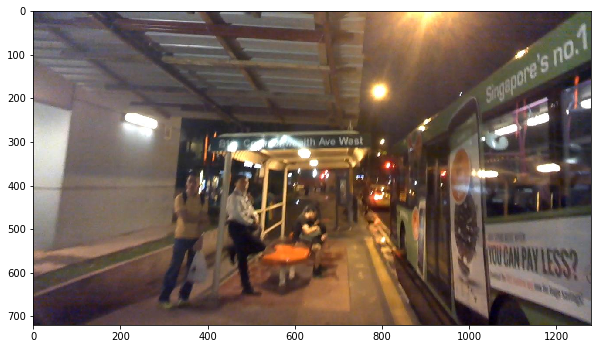

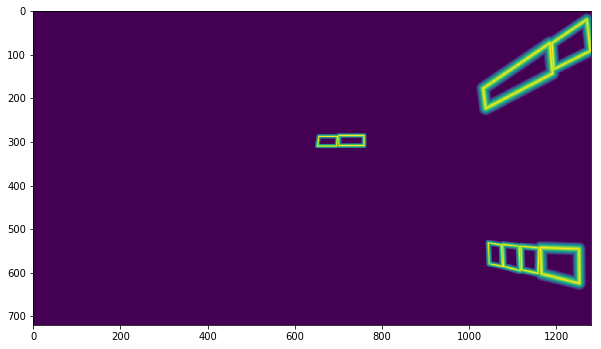

In [ ]:

from ppocr.data.imaug.make_border_map import MakeBorderMap

# 1. Declare the MakeBorderMap function
generate_text_border = MakeBorderMap()

# 2. Calculate bordermap information based on the decoded input data
data = generate_text_border(data)

# 3. Threshold graph visualization
plt.figure(figsize=(10, 10))
plt.imshow(src_img)

text_border_map = data['threshold_map']
plt.figure(figsize=(10, 10))
plt.imshow(text_border_map)


**Get Probability Map Labels**

Use the shrinking method to obtain the probability map labels needed for algorithm training.


In [ ]:

import numpy as np
import cv2
from shapely.geometry import Polygon
import pyclipper

class MakeShrinkMap(object):
    r'''
    Making binary mask from detection data with ICDAR format.
    Typically following the process of class `MakeICDARData`.
    '''

    def __init__(self, min_text_size=8, shrink_ratio=0.4, **kwargs):
        self.min_text_size = min_text_size
        self.shrink_ratio = shrink_ratio

    def __call__(self, data):
        image = data['image']
        text_polys = data['polys']
        ignore_tags = data['ignore_tags']

        h, w = image.shape[:2]
        # 1. Verification text detection label
        text_polys, ignore_tags = self.validate_polygons(text_polys,
                                                         ignore_tags, h, w)
        gt = np.zeros((h, w), dtype=np.float32)
        mask = np.ones((h, w), dtype=np.float32)

        # 2. Calculate the probability map of the text area according to the text detection box
        for i in range(len(text_polys)):
            polygon = text_polys[i]
            height = max(polygon[:, 1]) - min(polygon[:, 1])
            width = max(polygon[:, 0]) - min(polygon[:, 0])
            if ignore_tags[i] or min(height, width) < self.min_text_size:
                cv2.fillPoly(mask,
                             polygon.astype(np.int32)[np.newaxis, :, :], 0)
                ignore_tags[i] = True
            else:
                # Polygon indentation
                polygon_shape = Polygon(polygon)
                subject = [tuple(l) for l in polygon]
                padding = pyclipper.PyclipperOffset()
                padding.AddPath(subject, pyclipper.JT_ROUND,
                                pyclipper.ET_CLOSEDPOLYGON)
                shrinked = []

                # Increase the shrink ratio every time we get multiple polygon returned back
                possible_ratios = np.arange(self.shrink_ratio, 1,
                                            self.shrink_ratio)
                np.append(possible_ratios, 1)
                # print(possible_ratios)
                for ratio in possible_ratios:
                    # print(f"Change shrink ratio to {ratio}")
                    distance = polygon_shape.area * (
                        1 - np.power(ratio, 2)) / polygon_shape.length
                    shrinked = padding.Execute(-distance)
                    if len(shrinked) == 1:
                        break

                if shrinked == []:
                    cv2.fillPoly(mask,
                                 polygon.astype(np.int32)[np.newaxis, :, :], 0)
                    ignore_tags[i] = True
                    continue
                # filling
                for each_shrink in shrinked:
                    shrink = np.array(each_shrink).reshape(-1, 2)
                    cv2.fillPoly(gt, [shrink.astype(np.int32)], 1)

        data['shrink_map'] = gt
        data['shrink_mask'] = mask
        return data

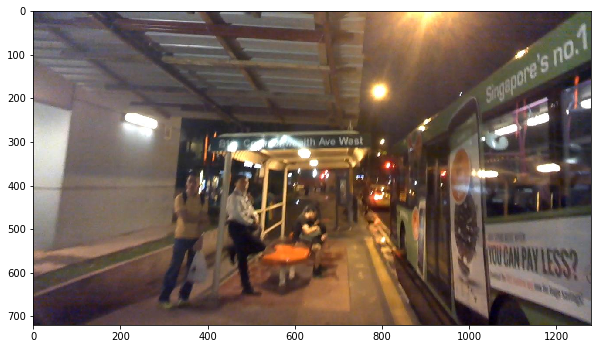

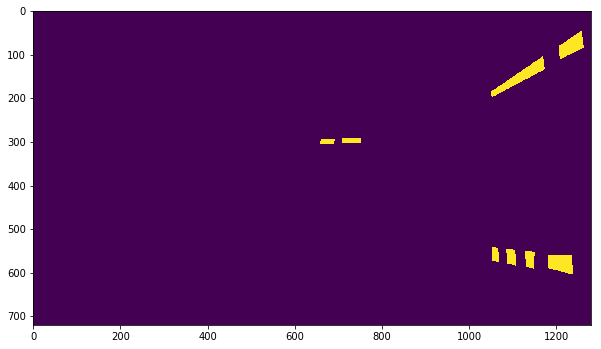

In [ ]:
from ppocr.data.imaug.make_shrink_map import MakeShrinkMap

# 1. Declare text probability map label generation
generate_shrink_map = MakeShrinkMap()

# 2. Calculate the probability map of the text area based on the decoded label
data = generate_shrink_map(data)

# 3. Visualization of Probability Map of Text Area
plt.figure(figsize=(10, 10))
plt.imshow(src_img)
text_border_map = data['shrink_map']
plt.figure(figsize=(10, 10))
plt.imshow(text_border_map)

**Normalized**

Through normalization, the input value distribution of any neuron in each layer of the neural network is changed to a standard normal distribution with a mean value of 0 and a variance of 1, so that the process of optimizing the optimal solution will obviously become smoother and the training process will be easier to converge.


In [ ]:
# Image normalization class
class NormalizeImage(object):
    """ normalize image such as substract mean, divide std
    """

    def __init__(self, scale=None, mean=None, std=None, order='chw', **kwargs):
        if isinstance(scale, str):
            scale = eval(scale)
        self.scale = np.float32(scale if scale is not None else 1.0 / 255.0)
        # 1. Get the normalized mean and variance
        mean = mean if mean is not None else [0.485, 0.456, 0.406]
        std = std if std is not None else [0.229, 0.224, 0.225]

        shape = (3, 1, 1) if order == 'chw' else (1, 1, 3)
        self.mean = np.array(mean).reshape(shape).astype('float32')
        self.std = np.array(std).reshape(shape).astype('float32')

    def __call__(self, data):
        # 2. Get image data from dictionary
        img = data['image']
        from PIL import Image
        if isinstance(img, Image.Image):
            img = np.array(img)
        assert isinstance(img, np.ndarray), "invalid input 'img' in NormalizeImage"

        # 3. Image normalization
        data['image'] = (img.astype('float32') * self.scale - self.mean) / self.std
        return data



**Channel Conversion**

The image data format is [H, W, C] (that is, the height, width, and number of channels), and the training data format used by the neural network is [C, H, W], so the image data needs to be rearranged, such as [ 224, 224, 3] becomes [3, 224, 224].

In [ ]:
# Change the channel order of the image, HWC to CHW
class ToCHWImage(object):
    """ convert hwc image to chw image
    """
    def __init__(self, **kwargs):
        pass

    def __call__(self, data):
        # 1. Get image data from dictionary
        img = data['image']
        from PIL import Image
        if isinstance(img, Image.Image):
            img = np.array(img)
        
        # 2. Change the channel order of the image by transposing
        data['image'] = img.transpose((2, 0, 1))
        return data
    
# 1. Declare the channel transformation class 
transpose = ToCHWImage()

# 2. Print the image before transformation
print("The shape of image before transpose", data['image'].shape)

# 3. Image channel transformation
data = transpose(data)

# 4. Print the transformed image to the channel
print("The shape of image after transpose", data['image'].shape)

The shape of image before transpose (720, 1280, 3)
The shape of image after transpose (3, 720, 1280)


## 3.3 Building a Data Reader


The above code only shows the method of reading a picture and preprocessing. In the actual model training, the method of batch data reading and processing is mostly used.

This section uses [Dataset](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/io/Dataset_cn.html) and [DatasetLoader](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/io/DataLoader_cn.html#dataloader) API to build data reader.

In [ ]:
import numpy as np
import os
import random
from paddle.io import Dataset

def transform(data, ops=None):
    """ transform """
    if ops is None:
        ops = []
    for op in ops:
        data = op(data)
        if data is None:
            return None
    return data


def create_operators(op_param_list, global_config=None):
    """
    create operators based on the config
    Args:
        params(list): a dict list, used to create some operators
    """
    assert isinstance(op_param_list, list), ('operator config should be a list')
    ops = []
    for operator in op_param_list:
        assert isinstance(operator,
                          dict) and len(operator) == 1, "yaml format error"
        op_name = list(operator)[0]
        param = {} if operator[op_name] is None else operator[op_name]
        if global_config is not None:
            param.update(global_config)
        op = eval(op_name)(**param)
        ops.append(op)
    return ops

    
class SimpleDataSet(Dataset):
    def __init__(self, mode, label_file, data_dir, seed=None):
        super(SimpleDataSet, self).__init__()
        # In the annotation file, use'\t' as a separator to distinguish the image name from the label
        self.delimiter ='\t'
        # Data set path
        self.data_dir = data_dir
        # Random number seed
        self.seed = seed
        # Get all the data and return it in the form of a list
        self.data_lines = self.get_image_info_list(label_file)
        # Create a new list to store data index
        self.data_idx_order_list = list(range(len(self.data_lines)))
        self.mode = mode
        # If it is a training process, randomly scramble the data set
        if self.mode.lower() == "train":
            self.shuffle_data_random()

    def get_image_info_list(self, label_file):
        # Get all the data in the label file
        with open(label_file, "rb") as f:
            lines = f.readlines()
        return lines

    def shuffle_data_random(self):
        #Random scramble data
        random.seed(self.seed)
        random.shuffle(self.data_lines)
        return

    def __getitem__(self, idx):
        # 1. Get data whose index is idx
        file_idx = self.data_idx_order_list[idx]
        data_line = self.data_lines[file_idx]
        try:
            # 2. Get the image name and label
            data_line = data_line.decode('utf-8')
            substr = data_line.strip("\n").split(self.delimiter)
            file_name = substr[0]
            label = substr[1]
            # 3. Get the image path
            img_path = os.path.join(self.data_dir, file_name)
            data = {'img_path': img_path,'label': label}
            if not os.path.exists(img_path):
                raise Exception("{} does not exist!".format(img_path))
            # 4. Read the picture and preprocess it
            with open(data['img_path'],'rb') as f:
                img = f.read()
                data['image'] = img

            # 5. Complete the data enhancement operation
            outs = transform(data, self.mode.lower())

        # 6. If the current data read fails, read a new data randomly again
        except Exception as e:
            outs = None
        if outs is None:
            return self.__getitem__(np.random.randint(self.__len__()))
        return outs

    def __len__(self):
        # Return the size of the data set
        return len(self.data_idx_order_list)

In [ ]:

from paddle.io import Dataset, DataLoader, BatchSampler, DistributedBatchSampler

def build_dataloader(mode, label_file, data_dir, batch_size, drop_last, shuffle, num_workers, seed=None):
    # Create data reading class
    dataset = SimpleDataSet(mode, label_file, data_dir, seed)
    # Define batch_sampler
    batch_sampler = BatchSampler(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    # Use paddle.io.DataLoader to create a data reader, and set batchsize, number of processes num_workers and other parameters
    data_loader = DataLoader(dataset=dataset, batch_sampler=batch_sampler, num_workers=num_workers, return_list=True, use_shared_memory=False)

    return data_loader


In [ ]:
ic15_data_path = "/home/aistudio/data/data96799/icdar2015/text_localization/"
train_data_label = "/home/aistudio/data/data96799/icdar2015/text_localization/train_icdar2015_label.txt"
eval_data_label = "/home/aistudio/data/data96799/icdar2015/text_localization/test_icdar2015_label.txt"

# Define the training set data reader, the number of processes is set to 8
train_dataloader = build_dataloader('Train', train_data_label, ic15_data_path, batch_size=8, drop_last=False, shuffle=True, num_workers=0)
# Define validation set data reader
eval_dataloader = build_dataloader('Eval', eval_data_label, ic15_data_path, batch_size=1, drop_last=False, shuffle=False, num_workers=0)


## 3.4 DB Model Post-processing

The output shape of the DB head network is the same as the original image. In fact, the three channel features output by the DB head network are the probability map, the threshold map and the binary map of the text area.

In the training phase, the three prediction maps and the real labels jointly complete the calculation of the loss function and model training.

In the prediction stage, only the probability map is needed. The DB post-processing function calculates the coordinates of the text box surrounding the text response area based on the response of the text area in the probability map.

Since the probability map predicted by the network is the result of shrinking, in the post-processing step, the predicted polygon area is expanded with the same offset value to obtain the final text box. The code implementation is shown below.

In [ ]:
import numpy as np
import cv2
import paddle
from shapely.geometry import Polygon
import pyclipper


class DBPostProcess(object):
    """
    The post process for Differentiable Binarization (DB).
    """

    def __init__(self,
                 thresh=0.3,
                 box_thresh=0.7,
                 max_candidates=1000,
                 unclip_ratio=2.0,
                 use_dilation=False,
                 score_mode="fast",
                 **kwargs):
        # 1. Obtain post-processing hyperparameters
        self.thresh = thresh
        self.box_thresh = box_thresh
        self.max_candidates = max_candidates
        self.unclip_ratio = unclip_ratio
        self.min_size = 3
        self.score_mode = score_mode
        assert score_mode in [
            "slow", "fast"
        ], "Score mode must be in [slow, fast] but got: {}".format(score_mode)

        self.dilation_kernel = None if not use_dilation else np.array(
            [[1, 1], [1, 1]])


    def __call__(self, outs_dict, shape_list):

        # 1. Get network prediction results from the dictionary
        pred = outs_dict['maps']
        if isinstance(pred, paddle.Tensor):
            pred = pred.numpy()
        pred = pred[:, 0, :, :]

        # 2. Greater than the post-processing parameter threshold self.thresh
        segmentation = pred > self.thresh

        boxes_batch = []
        for batch_index in range(pred.shape[0]):
            # 3. Get the shape and resize ratio of the original image
            src_h, src_w, ratio_h, ratio_w = shape_list[batch_index]
            if self.dilation_kernel is not None:
                mask = cv2.dilate(
                    np.array(segmentation[batch_index]).astype(np.uint8),
                    self.dilation_kernel)
            else:
                mask = segmentation[batch_index]
             
            # 4. Use the boxes_from_bitmap function to complete the calculation of the text box from the predicted text probability map
            boxes, scores = self.boxes_from_bitmap(pred[batch_index], mask,
                                                   src_w, src_h)

            boxes_batch.append({'points': boxes})
        return boxes_batch



You can find that each word is surrounded by a blue box. These blue boxes are obtained by doing some post-processing on the segmentation results output by the DB. Add the following code to line 177 of `PaddleOCR/ppocr/postprocess/db_postprocess.py` to visualize the segmentation map output by DB. The visualization result of the segmentation map is saved as the image vis_segmentation.png.

```python
_maps = np.array(pred[0, :, :] * 255).astype(np.uint8)
import cv2
cv2.imwrite("vis_segmentation.png", _maps)
```

In [ ]:

!python tools/infer_det.py -c configs/det/det_mv3_db.yml \
                           -o Global.checkpoints=./pretrain_models/det_mv3_db_v2.0_train/best_accuracy \
                              Global.infer_img=./doc/imgs_en/img_12.jpg 
                              #PostProcess.unclip_ratio=4.0

File ‘./pretrain_models/det_mv3_db_v2.0_train.tar’ already there; not retrieving.

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:241: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=np.bool)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:256: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details

Visualize the text probability map predicted by the predictive model and the final predicted text box result.

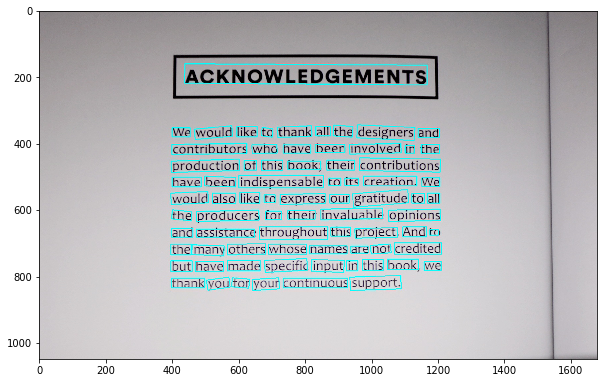

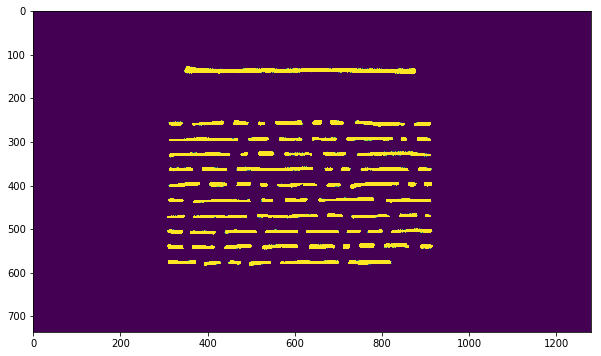

In [ ]:
img = Image.open('./output/det_db/det_results/img_12.jpg')
img = np.array(img)

# Draw the read picture
plt.figure(figsize=(10, 10))
plt.imshow(img)

img = Image.open('./vis_segmentation.png')
img = np.array(img)

# Draw the read picture
plt.figure(figsize=(10, 10))
plt.imshow(img)

From the visualization results, it can be found that the output result of the DB is a binary image of the text area. The response of the text area is higher, and the response value of the non-text background area is lower. The post-processing of DB is to find the minimum bounding box of these response areas, and then obtain the coordinates of each text area.
In addition, the size of the text box can be adjusted by modifying the post-processing parameters, or the text box with poor detection effect can be filtered.

There are four parameters for DB post-processing, namely:
- thresh: The threshold for binarization of the segmentation map in DBPostProcess, the default value is 0.3
- box_thresh: The threshold for filtering the output box in DBPostProcess. Boxes below this threshold will not be output
- unclip_ratio: the ratio of text box enlargement in DBPostProcess
- max_candidates: The maximum number of text boxes output in DBPostProcess, the default is 1000


In [ ]:

!python tools/infer_det.py -c configs/det/det_mv3_db.yml \
                           -o Global.checkpoints=./pretrain_models/det_mv3_db_v2.0_train/best_accuracy \
                              Global.infer_img=./doc/imgs_en/img_12.jpg \
                              PostProcess.unclip_ratio=4.0


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:241: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=np.bool)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:256: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0

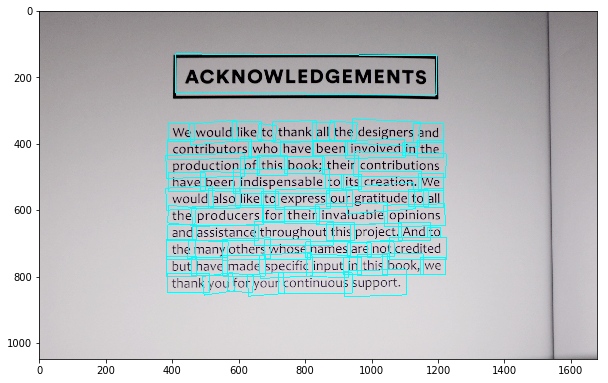

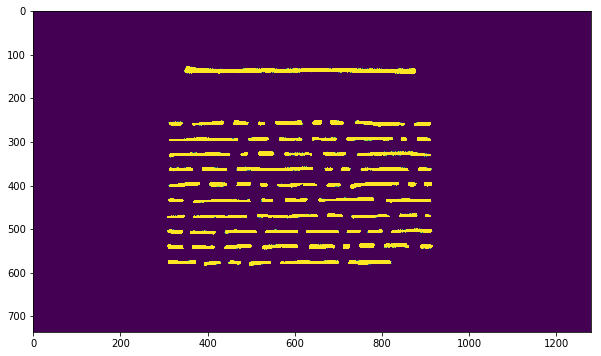

In [ ]:
img = Image.open('./output/det_db/det_results/img_12.jpg')
img = np.array(img)

# Draw the read picture
plt.figure(figsize=(10, 10))
plt.imshow(img)

img = Image.open('./vis_segmentation.png')
img = np.array(img)

# Draw the read picture
plt.figure(figsize=(10, 10))
plt.imshow(img)

From the running results of the above code, it can be found that after increasing the unclip_ratio parameter of the DB post-processing, the predicted text box becomes significantly larger. Therefore, when the training result does not meet our expectations, the text detection result can be adjusted by adjusting the post-processing parameters. In addition, you can try to adjust the other three parameters thresh, box_thresh, max_candidates to compare the detection results.

## 3.5 Loss Function Definition


Since three prediction maps are obtained in the training phase, in the loss function, it is also necessary to combine these three prediction maps and their corresponding real labels to construct three parts of the loss function respectively. The formula of the total loss function is defined as follows:

$L = L_b + \alpha \times L_s + \beta \times L_t$

Among them, $L$ is the total loss, $L_s$ is the probability map loss. In this experiment, the Dice loss with OHEM (online hard example mining) is used, and $L_t$ is the threshold map loss, which is used in this experiment. The $L_1$ distance between the predicted value and the label, $L_b$ is the loss function of the text binary graph. $\alpha$ and $\beta$ are the weight coefficients, which are set to 5 and 10 respectively in this experiment.

The three losses $L_b$, $L_s$, and $L_t$ are Dice Loss, Dice Loss (OHEM), and MaskL1 Loss. Next, define these three parts:

-Dice Loss is to compare the similarity between the predicted text binary image and the label. It is often used for binary image segmentation. Code implementation reference [link](https://github.com/PaddlePaddle/PaddleOCR/blob/81ee76ad7f9ff534a0ae5439d2a5259c4263993c/ppocr/losses/det_basic_loss.py?_pjax=%23js-repo-pjax-container%2C%20div%5Bitemtype%3D%22http%3A%2F%2Fschema.org%2FSoftwareSourceCode%22%5D%20main%2C%20%5Bdata-pjax-container%5D#L109). The formula is as follows:

$dice\_loss = 1 - \frac{2 \times intersection\_area}{total\_area}$

- Dice Loss (OHEM) uses Dice Loss with OHEM to improve the imbalance of positive and negative samples. OHEM is a special automatic sampling method that can automatically select difficult samples for loss calculation, thereby improving the training effect of the model. Here, the sampling ratio of positive and negative samples is set to 1:3. Code implementation reference [link](https://github.com/PaddlePaddle/PaddleOCR/blob/81ee76ad7f9ff534a0ae5439d2a5259c4263993c/ppocr/losses/det_basic_loss.py?_pjax=%23js-repo-pjax-container%2C%20div%5Bitemtype%3D%22http%3A%2F%2Fschema.org%2FSoftwareSourceCode%22%5D%20main%2C%20%5Bdata-pjax-container%5D#L95).
- MaskL1 Loss is to calculate the $L_1$ distance between the predicted text threshold map and the label.

In [ ]:

from paddle import nn
import paddle
from paddle import nn
import paddle.nn.functional as F



class DBLoss(nn.Layer):
    """
    Differentiable Binarization (DB) Loss Function
    args:
        param (dict): the super paramter for DB Loss
    """

    def __init__(self,
                 balance_loss=True,
                 main_loss_type='DiceLoss',
                 alpha=5,
                 beta=10,
                 ohem_ratio=3,
                 eps=1e-6,
                 **kwargs):
        super(DBLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        # Declare different loss functions
        self.dice_loss = DiceLoss(eps=eps)
        self.l1_loss = MaskL1Loss(eps=eps)
        self.bce_loss = BalanceLoss(
            balance_loss=balance_loss,
            main_loss_type=main_loss_type,
            negative_ratio=ohem_ratio)

    def forward(self, predicts, labels):
        predict_maps = predicts['maps']
        label_threshold_map, label_threshold_mask, label_shrink_map, label_shrink_mask = labels[
            1:]
        shrink_maps = predict_maps[:, 0, :, :]
        threshold_maps = predict_maps[:, 1, :, :]
        binary_maps = predict_maps[:, 2, :, :]
        # 1. For the text prediction probability map, use the binary cross-entropy loss function
        loss_shrink_maps = self.bce_loss(shrink_maps, label_shrink_map,
                                         label_shrink_mask)
        # 2. Use the L1 distance loss function for the text prediction threshold map
        loss_threshold_maps = self.l1_loss(threshold_maps, label_threshold_map,
                                           label_threshold_mask)
        # 3. For text prediction binary graph, use dice loss loss function
        loss_binary_maps = self.dice_loss(binary_maps, label_shrink_map,
                                          label_shrink_mask)

        # 4. Different loss functions are multiplied by different weights
        loss_shrink_maps = self.alpha * loss_shrink_maps
        loss_threshold_maps = self.beta * loss_threshold_maps

        loss_all = loss_shrink_maps + loss_threshold_maps \
                   + loss_binary_maps
        losses = {'loss': loss_all, \
                  "loss_shrink_maps": loss_shrink_maps, \
                  "loss_threshold_maps": loss_threshold_maps, \
                  "loss_binary_maps": loss_binary_maps}
        return losses

## 3.6 Evaluation Index

Considering that the DB post-processing detection frame is diverse and not level, this experiment uses a simple method of calculating IOU to evaluate. The calculation code refers to [icdar Challenges 4 text detection evaluation method](https://rrc.cvc.uab.es/?ch=4&com=mymethods&task=1).


There are three calculation indicators for text detection, namely Precision, Recall and Hmean. The calculation logic of the three indicators is:
1. Create a matrix of size [n, m] called iouMat, where n is the number of GT (ground truth) boxes, and m is the number of detected boxes; where n, m are the ### calibrated without the text Number of boxes
2. In iouMat, count the number of IOUs greater than the threshold 0.5, divide this value by the number n of gt to get Recall;
3. In iouMat, count the number of IOUs greater than the threshold 0.5, divide this value by the number of detection frames m to get Precision;
4. Hmean's index calculation method is the same as that of F1-score, and the formula is as follows:

$$
Hmean = 2.0* \frac{Precision * Recall}{Precision + Recall}
$$


The core code of text detection metric calculation is shown below, the complete code implementation reference [link](https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/ppocr/metrics/det_metric.py)：

In [ ]:

if len(gtPols)> 0 and len(detPols)> 0:
    outputShape = [len(gtPols), len(detPols)]

    # 1. Create a matrix of size [n, m] to save the calculated IOU
    iouMat = np.empty(outputShape)
    gtRectMat = np.zeros(len(gtPols), np.int8)
    detRectMat = np.zeros(len(detPols), np.int8)
    for gtNum in range(len(gtPols)):
        for detNum in range(len(detPols)):
            pG = gtPols[gtNum]
            pD = detPols[detNum]

            # 2. Calculate the IOU between the prediction box and the GT box
            iouMat[gtNum, detNum] = get_intersection_over_union(pD, pG)
    for gtNum in range(len(gtPols)):
        for detNum in range(len(detPols)):
            if gtRectMat[gtNum] == 0 and detRectMat[
                    detNum] == 0 and gtNum not in gtDontCarePolsNum and detNum not in detDontCarePolsNum:

                # 2.1 Count the number of IOUs greater than the threshold 0.5
                if iouMat[gtNum, detNum]> self.iou_constraint:
                    gtRectMat[gtNum] = 1
                    detRectMat[detNum] = 1
                    detMatched += 1
                    pairs.append({'gt': gtNum,'det': detNum})
                    detMatchedNums.append(detNum)
    
    # 3. Divide the number of IOUs greater than the threshold 0.5 by the number of GT boxes numGtcare to get the recall
    recall = float(detMatched) / numGtCare

    # 4. Divide the number of IOUs greater than the threshold 0.5 by the number of prediction boxes numDetcare to get precision
    precision = 0 if numDetCare == 0 else float(detMatched) / numDetCare

    # 5. Calculate the Hmean indicator by formula
    hmean = 0 if (precision + recall) == 0 else 2.0 * \
                                                    precision * recall / (precision + recall)
    

## 3.7 Model Training

After completing data processing, network definition and loss function definition, you can start training the model.

Training is based on PaddleOCR training, in the form of parameter configuration, parameter file reference [link](https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/configs/det/det_mv3_db.yml), network structure parameters as follows:
```yaml
Architecture:
  model_type: det
  algorithm: DB
  Transform:
  Backbone:
    name: MobileNetV3
    scale: 0.5
    model_name: large
  Neck:
    name: DBFPN
    out_channels: 256
  Head:
    name: DBHead
    k: 50
```

The optimizer parameters are as follows:
```yaml
Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    learning_rate: 0.001
  regularizer:
    name: 'L2'
    factor: 0
```

The post-processing parameters are as follows:
```yaml
PostProcess:
  name: DBPostProcess
  thresh: 0.3
  box_thresh: 0.6
  max_candidates: 1000
  unclip_ratio: 1.5
```

...

For the complete parameter configuration file, see [det_mv3_db.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.3/configs/det/det_mv3_db.yml).


In [ ]:
!mkdir train_data 
!cd train_data && ln -s /home/aistudio/data/data96799/icdar2015  icdar2015
!wget -P ./pretrain_models/ https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/MobileNetV3_large_x0_5_pretrained.pdparams

mkdir: cannot create directory ‘train_data’: File exists
--2021-12-22 22:04:50--  https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/MobileNetV3_large_x0_5_pretrained.pdparams
Resolving paddle-imagenet-models-name.bj.bcebos.com (paddle-imagenet-models-name.bj.bcebos.com)... 100.67.200.6
Connecting to paddle-imagenet-models-name.bj.bcebos.com (paddle-imagenet-models-name.bj.bcebos.com)|100.67.200.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16255295 (16M) [application/octet-stream]
Saving to: ‘./pretrain_models/MobileNetV3_large_x0_5_pretrained.pdparams.3’

MobileNetV3_large_x 100%[===================>]  15.50M  70.9MB/s    in 0.2s    

2021-12-22 22:04:50 (70.9 MB/s) - ‘./pretrain_models/MobileNetV3_large_x0_5_pretrained.pdparams.3’ saved [16255295/16255295]



In [67]:
!python tools/train.py -c configs/det/det_mv3_db.yml

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:241: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=np.bool)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:256: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0

The model after network training is saved in the `PaddleOCR/output/db_mv3/` directory by default. If you want to change the save directory, you can set the parameter Global.save_model_dir during training, such as:
```shell
# Set Global.save_model_dir in the parameter file to change the model save directory
python tools/train.py -c configs/det/det_mv3_db.yml -o Global.save_model_dir="./output/save_db_train/"
```



## 3.8 Model evaluation

During the training process, two models are saved by default, one is the latest trained model named latest, and the other is the most accurate model named best_accuracy. Next, use the saved model parameters to evaluate the precision, recall, and hmean on the test set:

The text detection accuracy evaluation code is located in `PaddleOCR/ppocr/metrics/det_metric.py`. You can call tools/eval.py to evaluate the accuracy of the trained model.

In [ ]:
!python tools/eval.py -c configs/det/det_mv3_db.yml -o Global.checkpoints=./output/db_mv3/best_accuracy

In addition to using the command line, `paddleocr` also provides a code calling method, as follows: